# Python scripting
This is the python script to automatically test the performanes of matrix-matrix multiplication in Fortran. We use a `Jupyter` notebook for simplicity.

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

## Run fortran code

In [2]:
outdir = './performances/'
fname  = 'perf_test'
dims   = [2**i for i in range(1, 13)]
n_iter = [100]*9 + [10] + [1]*len(dims[10:])

for i, dim in enumerate(dims):
    os.system("./exercise03a -m " + str(dim) + ' -n ' + str(n_iter[i]) + ' -o ' + outdir + fname)

Performance testing, 100.00% done.
Performance testing, 100.00% done.


Terminated


In [ ]:
# run this cell if u want only to read data and not produce them.
outdir = './performances/'
fname  = 'perf_test'
dims   = [2**i for i in range(1, 13)]
n_iter = [100]*9 + [10] + [1]*len(dims[10:])

## Read data

In [7]:

data_list = []

for dim in dims:
    tmp = np.loadtxt(outdir + fname + str(dim) + ".txt")
    dim1 = tmp.shape[0]
    dim2 = tmp.shape[1] if len(tmp.shape)==2 else 1
    data = pd.DataFrame(columns=['dim', 'type', 'time'])
    data['dim']  = [dim] * dim1*dim2
    data['type'] = ['matmul1']*dim2 + ['matmul2']*dim2 + ['matmul2_new']*dim2 + ['default']*dim2
    data['time'] = tmp.flatten()
    data_list.append(data.copy())

perf_df = pd.concat(data_list, ignore_index=True)
perf_df

,dim,type,time
0,2,matmul1,9.999960e-06
1,2,matmul1,1.000008e-06
2,2,matmul1,1.000008e-06
3,2,matmul1,9.998912e-07
4,2,matmul1,1.000008e-06
...,...,...,...
4019,2048,default,2.543945e+00
4020,4096,matmul1,1.156815e+03
4021,4096,matmul2,1.220006e+03
4022,4096,matmul2_new,2.606047e+03


## Fit results

First we dropout data not representative of the dependence we are searching, due to not enough precision in time measurements.

In [8]:
mask_dropout = (perf_df['dim']!=2) * (perf_df['dim']!=4)

Fit a polynomial of degree 1 to the log2 of the measurements -> the first parameter is the exponent of the expected relation between size and time

In [9]:
p1 = np.polyfit(x=np.log2(dims[2:]), y=np.log2(perf_df[(perf_df['type']=='matmul1') * mask_dropout].groupby('dim').mean()), deg=1)[:,0]
p2 = np.polyfit(x=np.log2(dims[2:]), y=np.log2(perf_df[(perf_df['type']=='matmul2') * mask_dropout].groupby('dim').mean()), deg=1)[:,0]
p3 = np.polyfit(x=np.log2(dims[2:]), y=np.log2(perf_df[(perf_df['type']=='matmul2_new') * mask_dropout].groupby('dim').mean()), deg=1)[:,0]
p_def = np.polyfit(x=np.log2(dims[2:]), y=np.log2(perf_df[(perf_df['type']=='default') * mask_dropout].groupby('dim').mean()), deg=1)[:,0]
p1[0], p2[0], p3[0], p_def[0]

(3.1191735503213747, 3.15282810076695, 3.264988280344939, 2.708057961436158)

The first 2 methods are pretty similar and near the expected value. The third one is the worst as expected. The default method as better performances

In [10]:
2**p1[1]

2.740300704773353e-09

## Display results

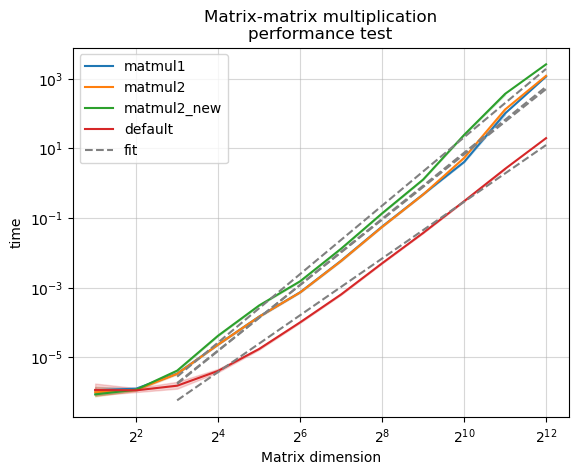

In [11]:
fig, ax = plt.subplots()

sns.lineplot(x = 'dim', y = 'time', hue = 'type', data = perf_df, ax=ax)

ax.plot(dims[2:], 2**p1[1]*dims[2:]**p1[0], ls ='dashed', c = 'grey')
ax.plot(dims[2:], 2**p2[1]*dims[2:]**p2[0], ls ='dashed', c = 'grey')
ax.plot(dims[2:], 2**p3[1]*dims[2:]**p3[0], ls ='dashed', c = 'grey')
ax.plot(dims[2:], 2**p_def[1]*dims[2:]**p_def[0], ls ='dashed', c = 'grey', label = 'fit')

ax.set_yscale('log')
ax.set_xscale(mpl.scale.LogScale(axis=0, base=2))
ax.set_xlabel('Matrix dimension')
ax.set_ylabel('time')
ax.set_title('Matrix-matrix multiplication\nperformance test')
ax.legend()
ax.grid(alpha=0.5)

fig.savefig('cubic_perf.svg')